<footer id="footer"></footer>


<center><b>Анализ клиентской базы фитнесс-центра</b></center>
  
<p align="center"><img src="https://i.ibb.co/mXM8xbR/gradient-home-gym-illustration-23-2148819451.jpg" alt="gradient-home-gym-illustration-23-2148819451" border="0">


Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.






---
    
<font size="2">  
    
- спрогнозировать вероятность оттока; 
    
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;    
    
- проанализировать основные признаки, наиболее сильно влияющие на отток;    
    
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:   
    
  - выделить целевые группы клиентов;    
    
  - предложить меры по снижению оттока;   
    
  - определить другие особенности взаимодействия с клиентами  
    
</font>




<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Импорт библиотек

Импортируем необходимые для работы библиотеки, создадим функции

In [ ]:
%%capture
!pip install shap

In [ ]:
%%capture
!pip install phik

In [ ]:
%%capture
!pip install SHFS

In [ ]:
import pandas as pd
import numpy as np 
import pylab
import scipy.stats as stats
import warnings
import shap

from SHFS import DFwrapper
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import mutual_info_classif

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
pd.set_option('chained_assignment', None)
np.random.seed(42)

Здесь соберем функции, которые будут использоваться в работе

In [ ]:
def score_model(y_test, y_pred):
    """функция для оценки качества моделей"""
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score (y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

def get_info(data):
    """функция для вывода основной информации по данным"""
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    data.info()
    print('----')
    print()
    
def qq_plt(data, col):
    """QQ-график"""
    measurements = data
    stats.probplot(measurements, dist="norm", plot=pylab)
    plt.title(f'QQ-график для {col}')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Упорядоченые значения')
    
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    """Попарное построение с учетом кластеров"""
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
    
def plot_cluster(data, cluster, features):
    """для построение графиков по кластерам"""
    hist_features = ['contract_period', 'month_to_end_contract','lifetime']
    fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
    cnt = 20
    for col, ax in zip(features, axes.flatten()):
        if col not in hist_features and col != 'avg_additional_charges_total':
            sns.distplot(data[data['cluster']==cluster][col], ax=ax, color=current_palette[cnt])
        elif col == 'avg_additional_charges_total':
            pass
        else:
            min_ = int(min(data[col]))    
            max_ = int(max(data[col]))
            sns.distplot(data[data['cluster']==cluster][col], ax=ax, color=current_palette[cnt], 
                         kde=False, norm_hist=True, bins = range(min_, max_+2))
        ax.set_title(f'Кластер {cluster}. \nПлотность распределения признаков \nпо целевой переменной для \n{col}')
        ax.set_ylabel('Плотность')
        
        cnt += 2

    plt.tight_layout()
    fig.show()
    plt.figure(figsize=(20, 6))
    col = 'avg_additional_charges_total'
    sns.distplot(data[data['cluster']==cluster][col], color=current_palette[cnt])
    plt.ylabel('Плотность')
    plt.title(f'Кластер {cluster}. \nПлотность распределения признаков \nпо целевой переменной для \n{col}')
    plt.show()
    
def make_mi_scores(X, y, discrete_features):
    """для получения взаимной информации"""
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mutual_information оценка', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    """для визуализации взаимной информации"""
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, ec='black', alpha=0.84)
    plt.yticks(width, ticks)
    plt.title('Взаимная информация')
    
def split_data(data, target_column):
    """для разделения данных на признаки и целевой признак"""
    return data.drop(columns=[target_column], axis=1), data[target_column]

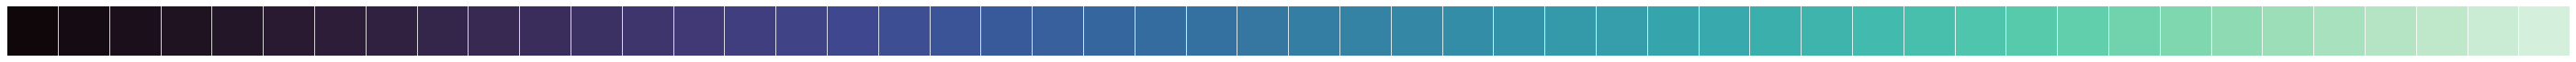

In [ ]:
current_palette = sns.color_palette('mako', 50)
sns.palplot(current_palette)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

##  Загрузка данных

###  Загрузка данных и первичный осмотр

Загрузим наши данные и посмотрим, с чем будем работать

In [ ]:
df = pd.read_csv('/datasets/gym_churn.csv')

```
Для Google Collab
%%capture
!gdown --id 1y5bWEAnnpip78mMaWswB2fulRIJnJwok

df = pd.read_csv('/content/gym_churn.csv')
```

In [ ]:
get_info(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory u

Ниже приведен атрибутный состав признаков:

`Churn` — факт оттока в текущем месяце - целевой признак;  

Данные клиента за предыдущий до проверки факта оттока месяц:
`gender` — пол;  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — 
в таком случае фитнес-центр хранит информацию о работодателе клиента);  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  
`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.  

В исходных данных не обнаружено пропусков, типы данных устраивают, не требуют преобразования. Для удобства, приведем названия признаков к нижнему регистру

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Проверим дубликаты

In [ ]:
print(f'Количество дубликатов в данных {df.duplicated().sum()}')

Количество дубликатов в данных 0


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


###  Вывод

 - данные в порядке, смогли прочитать,   
 - типы данных соответствуют ожидаемым,   
 - пропусков не наблюдается,   
 - дубликатов не наблюдается,   
 - названия признаков привели к нижнему регистру 
 
 
 Стоит отметить дисбаланс классов. Будем работать с ним в процессе прогнозирования

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


##  Исследовательский анализ данных (EDA)

### EDA. Общий обзор

Еще раз взглянем на сводную информацию о наших данных

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Явных аномалий не выявлено. Посмотрим на гистограммы наших признаков. Наблюдается перекос данных вправо у признака `avg_additional_charges_total`, 	`avg_class_frequency_current_month`, `avg_class_frequency_total`

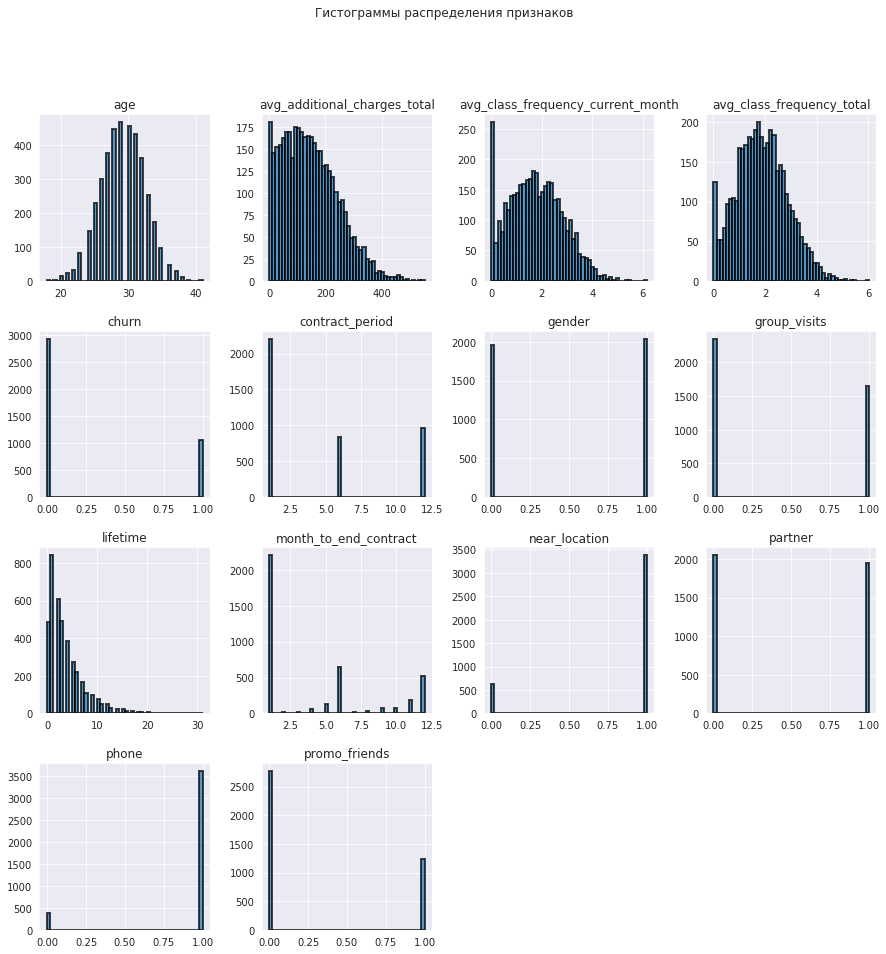

In [ ]:
axes = df.hist(bins=50, figsize=(15,15), edgecolor='black', linewidth=2, alpha=.72)
plt.suptitle('Гистограммы распределения признаков')
plt.show()

Наши выводы подтверждаются. Для улучшения обобщения - будем применять Стандартизацию в процессе построения прогнозов

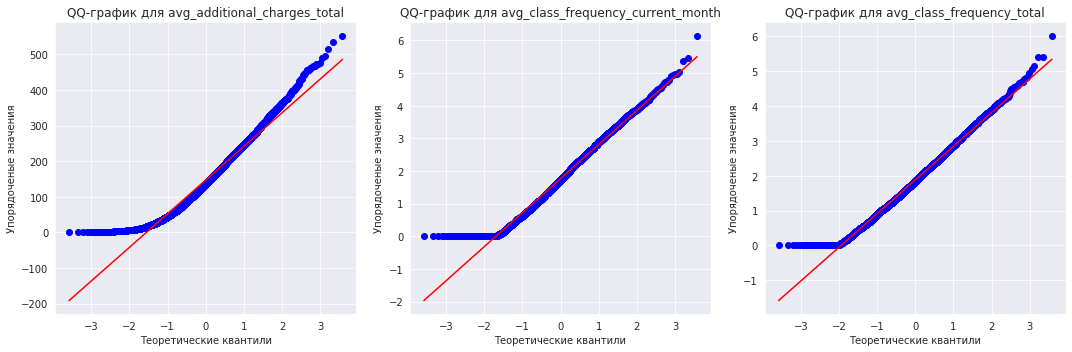

In [ ]:
cols = ['avg_additional_charges_total', 'avg_class_frequency_current_month', 'avg_class_frequency_total']
fig = plt.figure(figsize=(15,5))
for idx, col in enumerate(cols):
    fig.add_subplot(1, 3, idx+1)
    qq_plt(df[col], col)
    plt.tight_layout()

Стандартизация будем к месту - видим отклонения от нормального распределения. Чтобы уравнять модели - для линейной и леса - будет использовать идентичные условия. Посмотрим на средние значения признаков в двух группах.

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### EDA. Распределния по целевой переменной для признаков

In [ ]:
df.groupby('churn').agg('mean').T.style.set_caption('Данные по распределению признаков')

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.74719,1.72856
group_visits,0.464103,0.268615
age,29.9765,26.9896
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.28309,1.66258


In [ ]:
df['churn'].value_counts(normalize=True).to_frame('Баланс классов')

,Баланс классов
0,0.73475
1,0.26525


Данные достаточно несбалансированы по целевой переменной - будем использовать техники балансировки. Можно обратить внимание, что реже ухотят те, кто живет ближе, либо пришел из компании по программе партнерства, или те, кого пригласили друзья. Те пользователи, что реже ухотят - склонны заключать долгосрочные контракты, а также посещать групповые занятия. Те, кто реже уходят - чаще ходят в зал заниматься

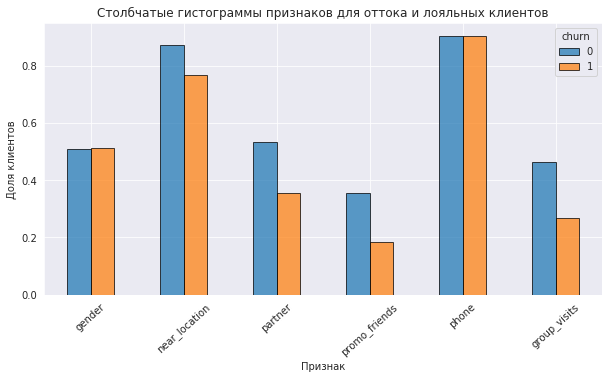

In [ ]:
features = ['gender','near_location','partner','promo_friends','phone','group_visits']

df.groupby('churn')[features].agg('mean').T.plot(kind='bar', 
                                                        stacked=False, 
                                                        figsize=(10, 5), ec='black',
                                                        alpha=.72
                                                 
                                                       )
plt.title('Cтолбчатые гистограммы признаков для оттока и лояльных клиентов')
plt.xlabel('Признак')
plt.ylabel('Доля клиентов')
plt.xticks(rotation=42)
plt.show()

Как мы и говорили - стоит отметить, что пользователи, пришедшие по рекомендациям друзей, либо по партнерской программе, либо посещающие групповые занятия - реже уходят. Также посмотрим на распределения непрерывных признаков

In [ ]:
real_features = ['lifetime',
                 'month_to_end_contract',
                 'contract_period',
                 'age',
                 'avg_class_frequency_total',
                 'avg_class_frequency_current_month',
                 'avg_additional_charges_total']
hist_features = ['contract_period', 'month_to_end_contract','lifetime']

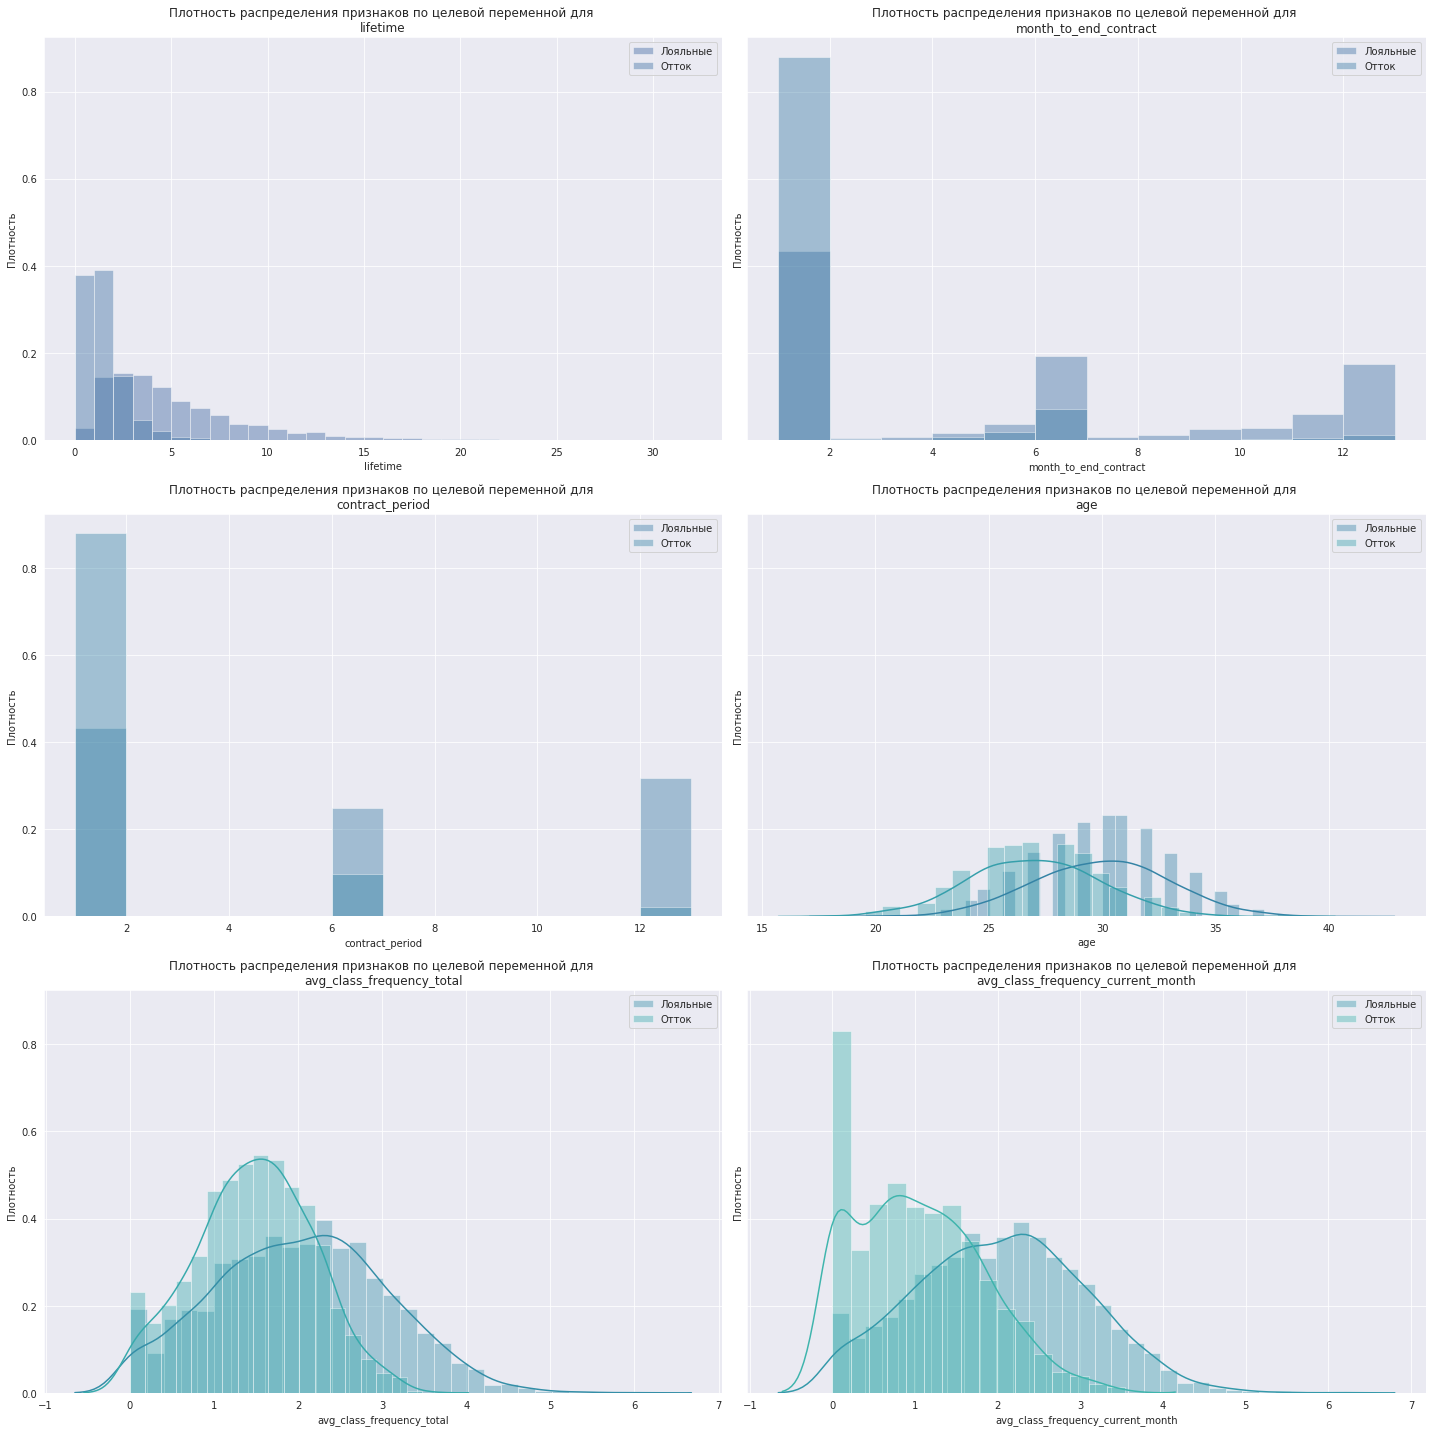

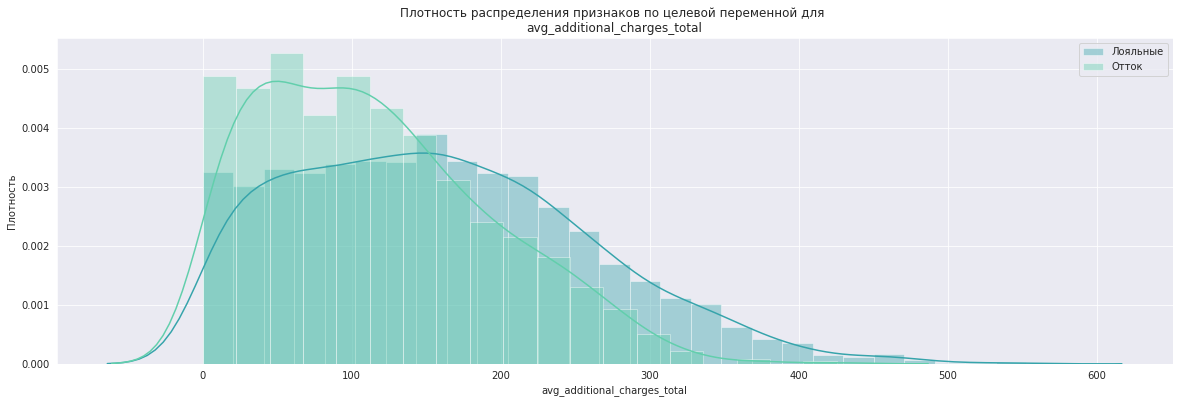

In [ ]:
churn = df[df['churn'] == 1]
loyal = df[df['churn'] == 0]
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharey=True)
cnt = 20
for col, ax in zip(real_features, axes.flatten()):
    if col not in hist_features and col != 'avg_additional_charges_total':
        sns.distplot(loyal[col], ax=ax, color=current_palette[cnt])
        sns.distplot(churn[col], ax=ax, color=current_palette[cnt + 5])
    else:
        min_ = int(min(df[col]))    
        max_ = int(max(df[col]))
        sns.distplot(loyal[col], ax=ax, color=current_palette[cnt], 
                     kde=False, norm_hist=True, bins = range(min_, max_+2))
        sns.distplot(churn[col], ax=ax, color=current_palette[cnt + 2], kde=False, 
                     norm_hist=True, bins = range(min_, max_+2))
    labels= ['Лояльные', 'Отток']
    ax.set_title(f'Плотность распределения признаков по целевой переменной для \n{col}')
    ax.set_ylabel('Плотность')
    ax.legend(labels)
    cnt += 2

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
col = 'avg_additional_charges_total'
sns.distplot(loyal[col], color=current_palette[cnt])
sns.distplot(churn[col], color=current_palette[cnt + 8])
plt.legend(labels)
plt.ylabel('Плотность')
plt.title(f'Плотность распределения признаков по целевой переменной для \n{col}')
plt.show()

Проще уходят те, кто покупает недолгосрочные абонементы. Молодые пользователи - легче покидают фитнесс-центр. Лояльные клиенты - чаще посещают центр для тренировок. Стоит отметить, что ушедшие клиенты, вначале месяца много занимались, затем покинули центр - им либо не понравилось качество тренировок, либо потеря имеет место быть мотивации. Посмотрим как коррелируют наши признаки:

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### EDA. Корреляция

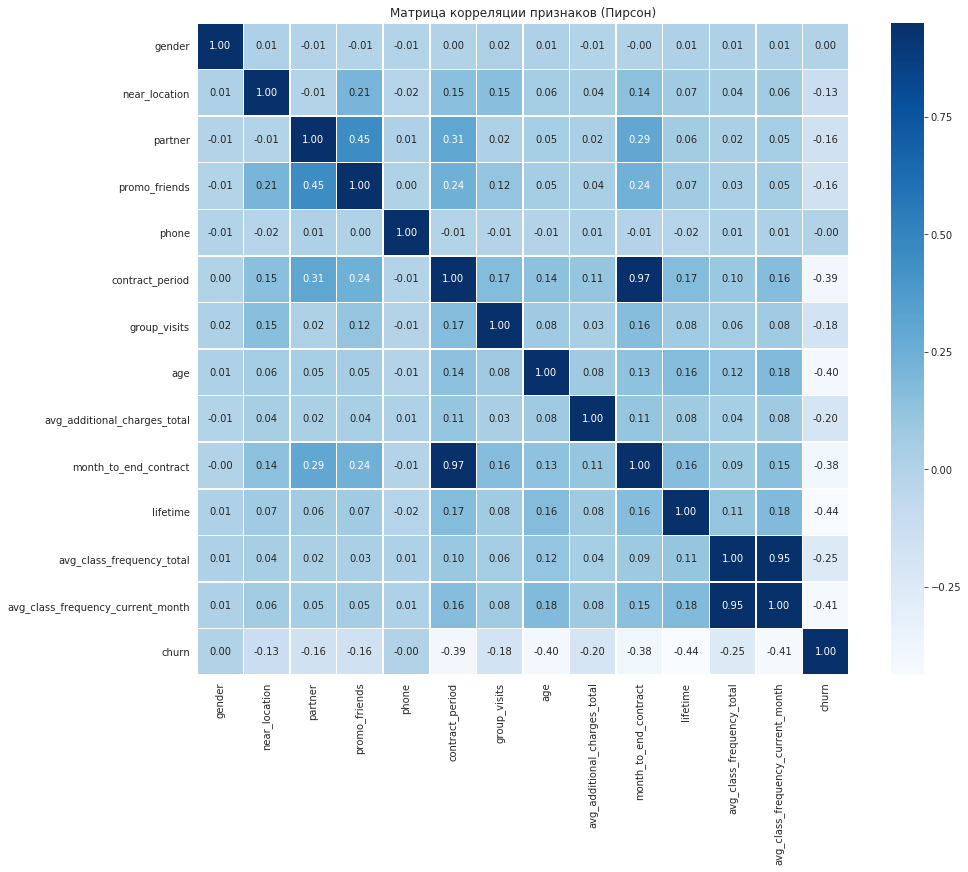

In [ ]:
corr = df.corr()

plt.figure(figsize = (15, 12))
sns.heatmap(corr, square = True, annot = True, fmt=".2f", cmap='Blues',
           linewidths=.42, vmax=.95)
plt.title('Матрица корреляции признаков (Пирсон)')
plt.show()

Есть две пары скоррелированных признаков:

`contract_period` и `month_to_end_contract`
`avg_class_frequency_total` и `avg_class_frequency_current_month`. Посмотрим также [phik](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7) корреляцию - умеет работать с категориальными переменными и выявлять зависимости нелинейного характера

In [ ]:
interval = list(df.columns)

In [ ]:
interval.remove('churn')

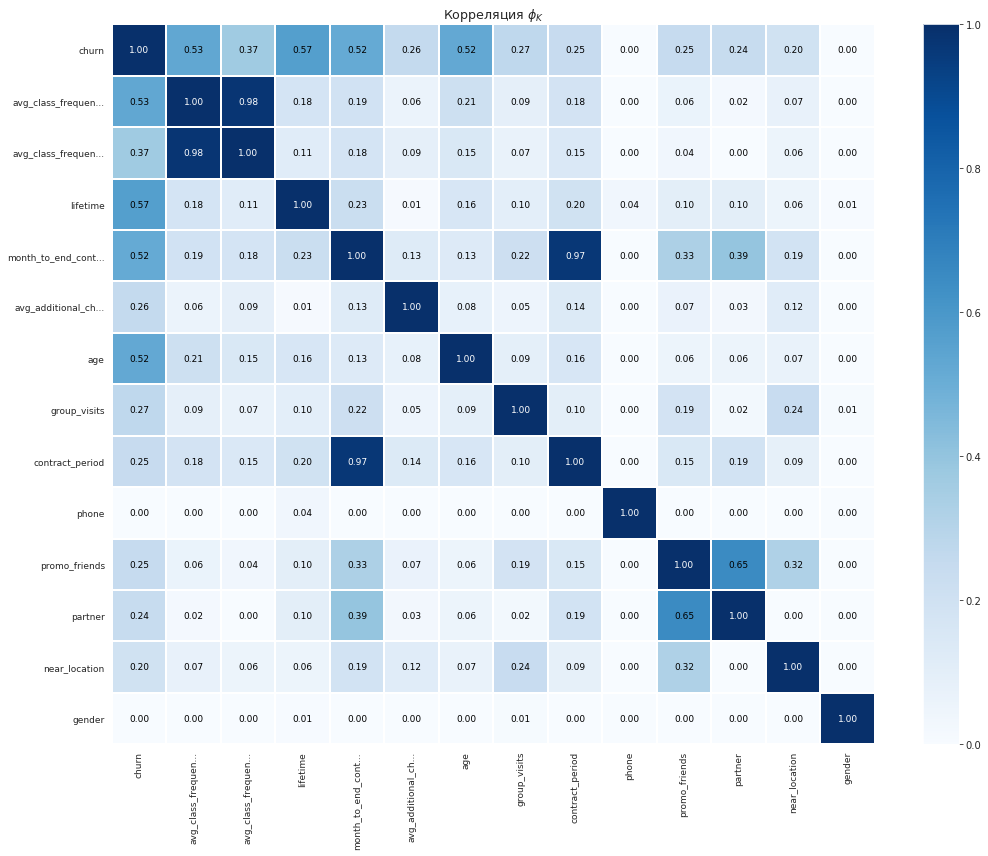

In [ ]:
phik_overview = df.phik_matrix(interval_cols=interval)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=.9, 
                        figsize=(15, 12))
plt.tight_layout()

`phik` выявила сильную, но не критичную корреляцию по признакам `promo_friends` и `partner`. Очистим данные от сильно скоррелированных признаков - порог `.9`

In [ ]:
cleaner = DFwrapper(thresh=0.9)
new_df = cleaner.wrap_corr(df)

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


Проверим наши преобразования:

In [ ]:
print(f'Удалили: {list(set(df.columns) - set(new_df.columns))}')

Удалили: ['month_to_end_contract', 'avg_class_frequency_current_month']


In [ ]:
new_df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


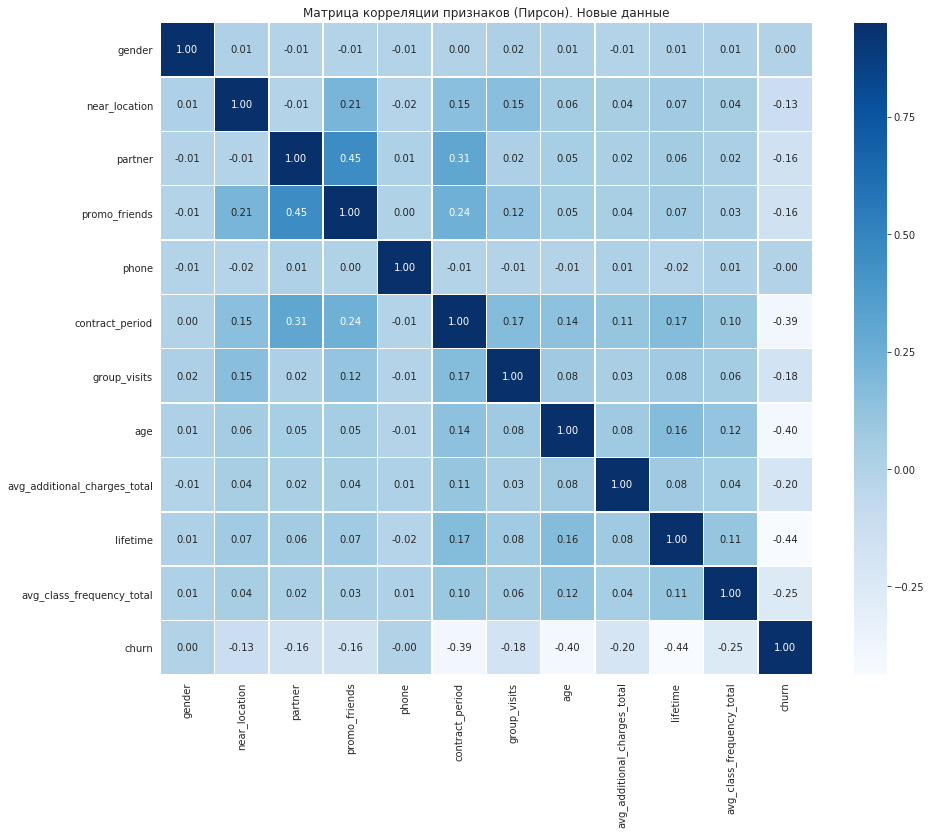

In [ ]:
corr = new_df.corr()

plt.figure(figsize = (15, 12))
sns.heatmap(corr, square = True, annot = True, fmt=".2f", cmap='Blues',
           linewidths=.42, vmax=.95)
plt.title('Матрица корреляции признаков (Пирсон). Новые данные')
plt.show()

Отлично, сильно скоррелированных признаков нет

Посмотрим взаимную информацию в наших целочисленных признаках

In [ ]:
X = new_df.copy()
y = X.pop('churn')

discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3].to_frame('Mi_scores')

,Mi_scores
lifetime,2.105083e-01
avg_class_frequency_total,5.852506e-02
promo_friends,1.405381e-02
phone,6.914092e-07


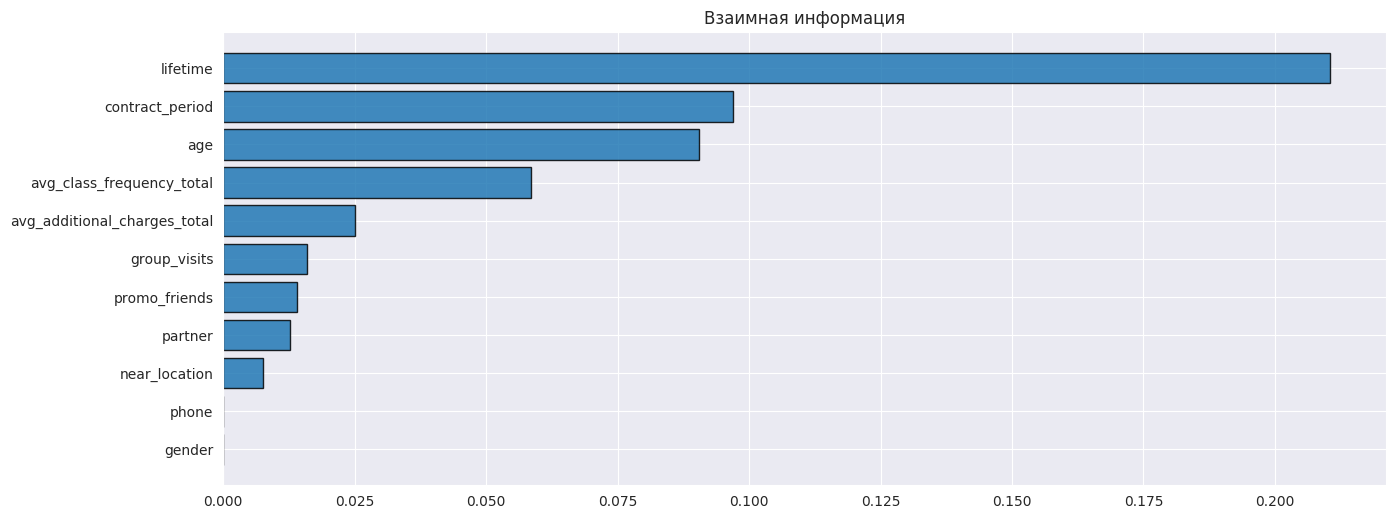

In [ ]:
plt.figure(dpi=100, figsize=(15, 6))
plot_mi_scores(mi_scores)

Больше всего влияние содержится в признаки `lifetime`. Думаю - этот признак будет оказывать наибольшее влияние на наши предсказания

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


###  Вывод

- наблюдается сильный дисбаланс классов;
- выбросы решили не проверять - предсказываем на всех клиентах, сильных аномалий не обнаружено
- доли мужчин и женщин - выборка стратифицирована по данному показателю
- чаще остаются:  
  - те, кто пришел по программе `приведи друга`
  - те, у кого более продолжительный абонимент
  - те, кто ходит на групповые занятия


Были обнаружены сильно скоррелированные признаки. Принято решение удалить их из данных



<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


##  Модель прогнозирования оттока клиентов

### Подготовка к построению модели

Разделим выборки на тестовую и обучающую

In [ ]:
X, y = split_data(new_df, 'churn')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
assert X_train.shape[0] == y_train.shape[0] and \
X_train.shape[0] + X_test.shape[0] == X.shape[0], 'Проверить разделение выборки'

assert не сработал, разделение отработало. Стандартизируем наши данные(бинарные не трогаем)

In [ ]:
X_train.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
3994,1,1,0,0,1,1,0,26,31.066721,1,1.157451
423,0,1,0,0,1,6,0,31,144.690532,5,1.669950
2991,0,1,0,0,0,12,0,31,158.273433,1,1.064901
1221,1,1,1,1,1,6,1,33,273.923731,12,1.374173
506,0,1,1,1,1,1,1,34,40.926455,4,3.341218


In [ ]:
num_features = ['contract_period', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']

Стандартизируем наши данные:

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [ ]:
X_train.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
3994,1,1,0,0,1,-0.805487,0,-0.983689,-1.208398,-0.729186,-0.739683
423,0,1,0,0,1,0.290041,0,0.558748,-0.019463,0.355736,-0.211141
2991,0,1,0,0,0,1.604674,0,0.558748,0.122666,-0.729186,-0.835130
1221,1,1,1,1,1,0.290041,1,1.175723,1.332806,2.254349,-0.516176
506,0,1,1,1,1,-0.805487,1,1.484210,-1.105228,0.084505,1.512443


Можем приступать к построению моделей. В `pipeline` нет необходимости - у нас всего лишь одно преобразование

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Линейная модель

В качестве модели, будем использовать `LogisticRegression`, также важно выставить `class_weight`. Для подбора параметров, воспользуемся простым `GridSearchCV`

In [ ]:
lg_model = LogisticRegression(class_weight='balanced')

In [ ]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_lr = GridSearchCV(lg_model, param_grid=grid_values)

In [ ]:
model_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [ ]:
lg_model = model_lr.best_estimator_

In [ ]:
y_preds = lg_model.predict(X_test)
score_model(y_preds, y_test)

Accuracy: 0.87
Precision: 0.89
Recall: 0.68


In [ ]:
coefs = lg_model.coef_
flat_list = [item for sublist in coefs for item in sublist]
features = pd.DataFrame({'feature': X_train.columns, 'coeff': flat_list})
features['coeff_abs'] = abs(features['coeff'])

In [ ]:
features.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
9,lifetime,-3.622615,3.622615
5,contract_period,-1.328770,1.328770
7,age,-1.165178,1.165178
10,avg_class_frequency_total,-0.728059,0.728059
6,group_visits,-0.695190,0.695190
8,avg_additional_charges_total,-0.558221,0.558221
3,promo_friends,-0.492572,0.492572
1,near_location,-0.364665,0.364665
4,phone,-0.270916,0.270916
0,gender,0.194156,0.194156


Как и ожидалось - больше всего влияния оказывают признаки `lifetime` и `contract_period`

Достаточно низкие показатели по `recall` - выбираем не всех ушедших. Но при этом, `precision` на достаточно высоком уровне. Если это удовлетворительно для заказчика - подбирать порог не требуется. Можно предложить - смещать баланс в сторону `recall`-`precision`. Попробуем сделать предсказания без балансировки классов

In [ ]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_preds = lg_model.predict(X_test)

In [ ]:
score_model(y_preds, y_test)

Accuracy: 0.90
Precision: 0.79
Recall: 0.81


В таком случае, мы немного увеличиваем `recall`, но снижаем `precision`. Необходимы уточнения от заказчика о важности предсказывать `1` и насколько критичны `FP`

Попробуем сделать кросс-валидацию и отбор признаков

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
params = [{'n_features_to_select': list(range(1, X_train.shape[1] + 1))}]
lm = LogisticRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True)      


model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RFE(estimator=LogisticRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)

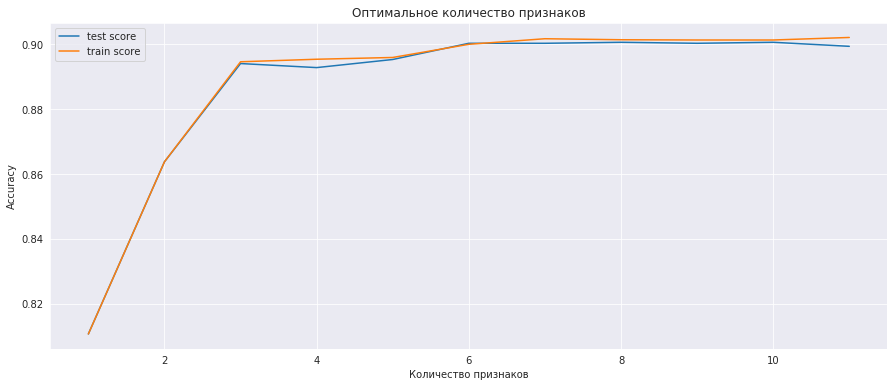

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Количество признаков')
plt.ylabel('Accuracy')
plt.title("Оптимальное количество признаков")
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

Мы видим, что уже на 6 признаках довольно неплохое качество - остальные - не значимы для модели

In [ ]:
n_features_optimal = 6

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features_optimal)
lm = LogisticRegression()
pipeline = Pipeline(steps=[('selected',rfe), ('model',lm)])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score_model(y_pred, y_test)

Accuracy: 0.90
Precision: 0.81
Recall: 0.80


Качество, чуть лучше, чем на всех признаках

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Случайный лес

Делаем уклон в сторону `precision` - выставим вес классов на сбалансированный. Попробуем перебрать немного параметров

In [ ]:
params = [{'n_estimators': [50, 100, 500],
           'class_weight':[None, 'balanced'],
           'min_samples_leaf': [50, 100, 500],
           'max_depth': [5, 7]}]
rnd_clf = RandomForestClassifier(random_state=42)         
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
model_cv = GridSearchCV(estimator = rnd_clf, 
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True)   

In [ ]:
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'max_depth': [5, 7],
                          'min_samples_leaf': [50, 100, 500],
                          'n_estimators': [50, 100, 500]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
rf_clf = model_cv.best_estimator_ 

In [ ]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=50, random_state=42)

In [ ]:
y_preds = rf_clf.predict(X_test)
score_model(y_preds, y_test)

Accuracy: 0.89
Precision: 0.66
Recall: 0.86


Потеряли в precision. но зато отбираем больше 1

Если понадобится интерпретируемость - необходимо использовать Дерево принятия решений, вместо леса

In [ ]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

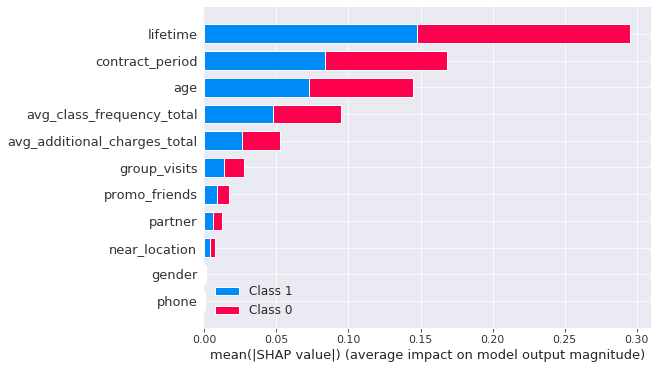

In [ ]:
shap.summary_plot(shap_values, X_test)

Снова видим, аналогично полученным во взанимной информации результатам - больше всего влияния оказывает `lifetime`, `contract_period`, `age`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Проверка на адекватность

Проверим наши модели на адекватность. Возьмем DummyClassifier, стратегию - стратифицированная - у нас дисбаланс

In [ ]:
dummy = DummyClassifier(strategy='stratified')

In [ ]:
dummy.fit(X_train, y_train)
y_preds = dummy.predict(X_test)
score_model(y_preds, y_test)

Accuracy: 0.62
Precision: 0.28
Recall: 0.26


Везде предсказывать 0 - бессмысленно - мы смотрим отток. Везде ставить 1 - аналогично - вырастут расходы на удержание, зачастую неоправданно

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Вывод

Модели по производительности не сильно отличаются. Необходимо решать - смещаться в сторону `precision` или `recall`. Если нужна более явная интерпретация - остановим свой выбор на модели логистической регрессии и тут у нас выше `precision`. Наши модели лучше, чем случайная - можно работать в данном направлении. Для улучшения качества предсказаний - можно попробвать использовать градиентный бустинг либо стэккинг

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


##  Кластеризация клиентов

### Агломеративная иерархическая кластеризация

In [ ]:
X = new_df.copy()

In [ ]:
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

In [ ]:
X.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,0.289890,1,-0.056554,-1.377531,-0.193329,-1.911920,0
1,0,1,0,0,1,1.608822,1,0.557327,-0.350213,0.873680,0.045176,0
2,0,1,1,0,1,-0.809219,0,-0.363494,-0.181592,-0.460081,-0.020493,0
3,0,1,1,1,1,1.608822,1,1.171208,-0.874722,-0.460081,1.364655,0
4,1,1,1,1,1,-0.809219,0,-0.977375,0.533700,-0.193329,-0.787076,0


In [ ]:
linked = linkage(X.drop('churn', axis=1), method = 'ward')

Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуему дендрограмму

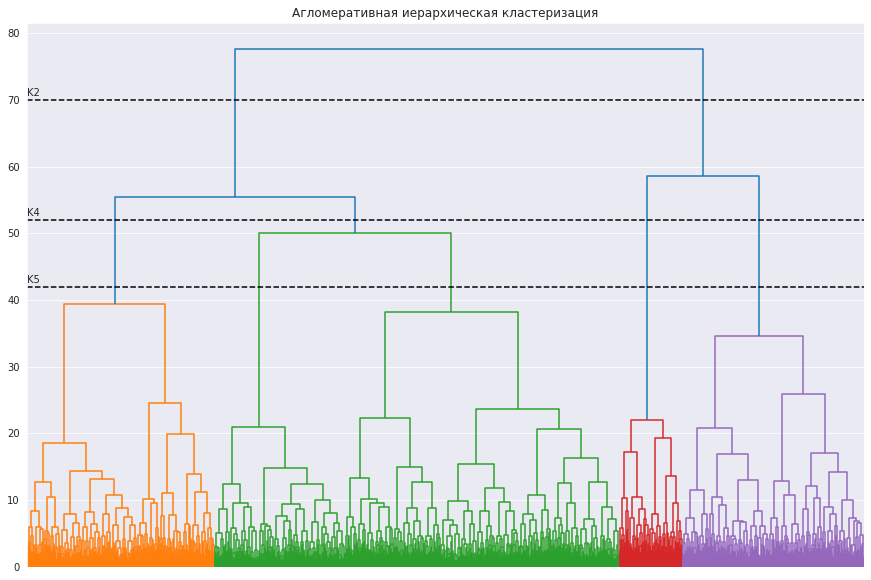

In [ ]:
xmax = 70000
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Агломеративная иерархическая кластеризация')
plt.hlines(y=70, xmin=-1, xmax=xmax, linestyle='--')
plt.text(25, 71, 'K2', ha='left', va='center')
plt.hlines(y=52, xmin=-1, xmax=xmax, linestyle='--')
plt.text(25, 53, 'K4', ha='left', va='center')
plt.hlines(y=42, xmin=-1, xmax=xmax, linestyle='--')
plt.text(25, 43, 'K5', ha='left', va='center')
plt.xticks([])
plt.show()

Можем выделить 5 кластеров. Построим `Kmeans` с 5 кластерами. Потом проверим методом локтя

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Модель кластеризации на основании алгоритма K-Means

Возьмем 5 кластеров и обучим модель

In [ ]:
km = KMeans(n_clusters = 5, random_state=42)
labels = km.fit_predict(X)

Проверим, насколько наш выбор оптимален

In [ ]:
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    distortion.append(model.inertia_) 

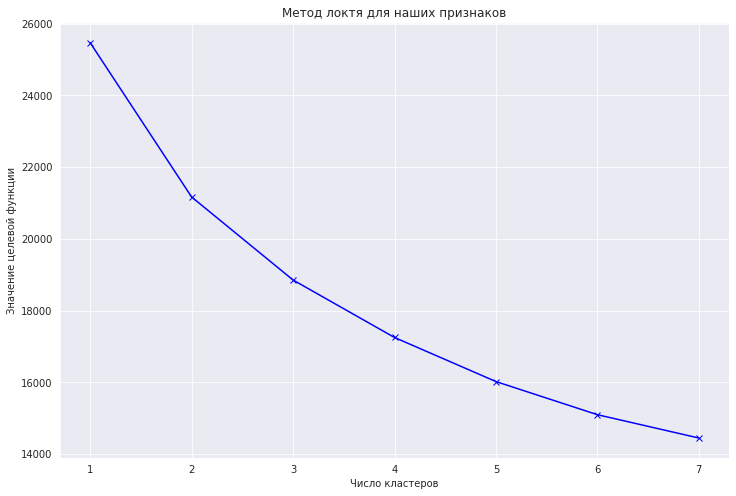

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.title('Метод локтя для наших признаков')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

Метод локтя также подтвердил, что 5 кластеров будет оптимально для наших данных. Сгруппируем наши данные по кластерам и посмотрим признаки по средним значениям

In [ ]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X, labels)))

Silhouette_score: 0.14


Значение метрики не сильно высокое, думаю, что если мы будем сравнивать попарно наши признаки - мы не выявим четко отделяемых групп. 

In [ ]:
new_df['cluster'] = labels
new_df['cluster'] += 1
new_df.groupby('cluster').mean().T.style.set_caption('Данные по распределению признаков(относительно кластеров)')

cluster,1,2,3,4,5
gender,0.522013,0.513825,0.497742,0.543536,0.491329
near_location,0.821803,0.940092,0.777778,0.883905,0.845376
partner,0.430818,0.726959,0.368564,0.503958,0.442197
promo_friends,0.256813,0.5,0.206865,0.340369,0.284682
phone,0.903564,0.900922,0.906956,0.875989,0.916185
contract_period,2.56184,11.8825,1.84914,5.02902,2.9104
group_visits,0.41195,0.549539,0.303523,0.461741,0.387283
age,31.3396,29.9194,26.3189,29.4802,29.7124
avg_additional_charges_total,94.4585,159.891,104.773,147.264,270.346
lifetime,3.25367,3.78917,1.42999,12.3747,3.22688


Мы видим, что по гендеру различий между кластерами нет, также как и по расстоянию до центра. Мы можем видеть, что есть различия по признаку `partner`, `promo_friends`. Сильные различия по признаку `contract_period`, `age`, а также по средним показателям платежей и частоты посещения
Мы видим, что наибольшее количество пользоваталей уходит в 4 кластере, наименьшее в 2 и 3.

Можно выделить признаки "хороших" кластеров:

- пришли по программе partner либо по приглашению друга
- у них длительные контракты
- чаще посещают групповые занятия
- больше расходуют (что следует из продолжительности пребывания в качестве клиента)
 

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Распределения признаков для кластеров

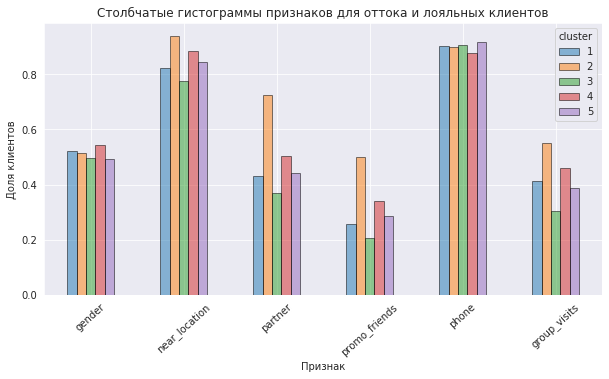

In [ ]:
features = ['gender','near_location','partner','promo_friends','phone','group_visits']

new_df.groupby('cluster')[features].agg('mean').T.plot(kind='bar', 
                                                        stacked=False, 
                                                        figsize=(10, 5), ec='black',
                                                        alpha=.5
                                                 
                                                       )
plt.title('Cтолбчатые гистограммы признаков для оттока и лояльных клиентов')
plt.xlabel('Признак')
plt.ylabel('Доля клиентов')
plt.xticks(rotation=42)
plt.show()

Как мы и наблюдали - различия есть в `partner` признаке и `promo`:

`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

In [ ]:
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000


In [ ]:
real_features = ['lifetime',
                 'contract_period',
                 'age',
                 'avg_class_frequency_total',
                 'avg_additional_charges_total']

Посмотрим на доли оттока по кластерам

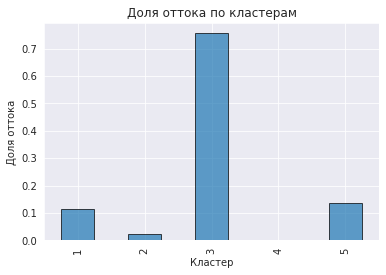

In [ ]:
(new_df.groupby('cluster')['churn']
 .agg('mean')
 .plot(kind='bar', ec='black', alpha=.7)
)
plt.title('Доля оттока по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Доля оттока')    
plt.show()

Имеется два кластера с сильной долей оттока, есть кластер с минимальным оттоком. Посмотрим как распредлены признаки для наших кластеров и попробуем составить рекомендации

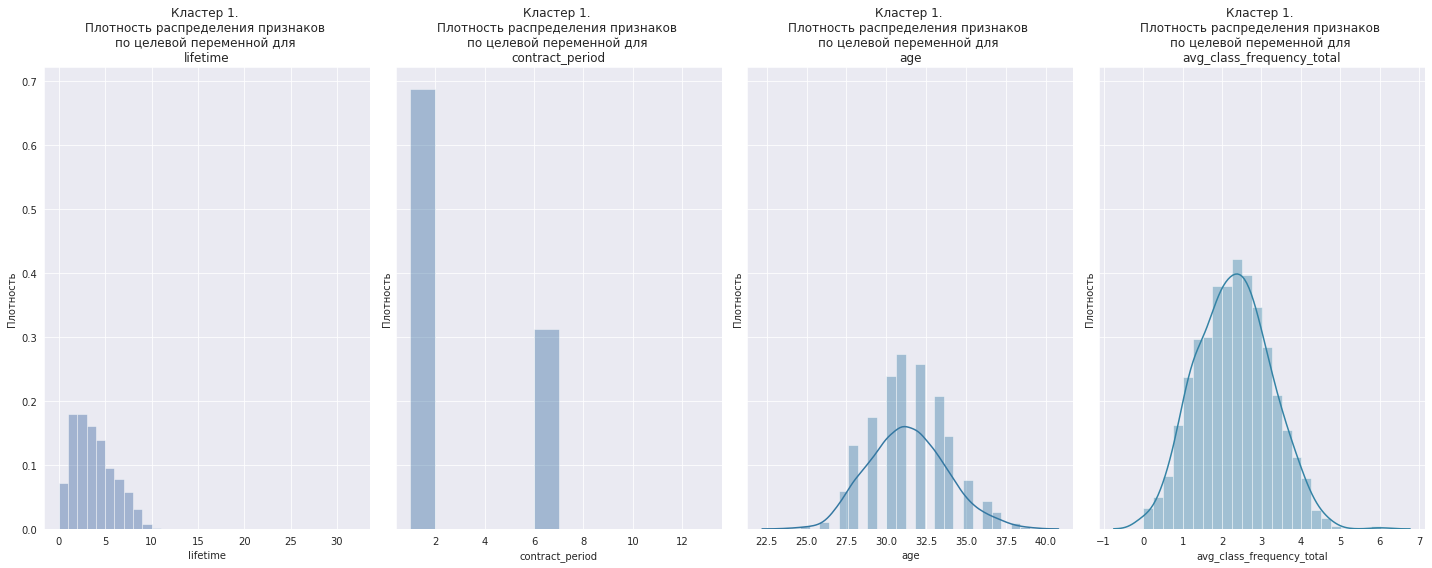

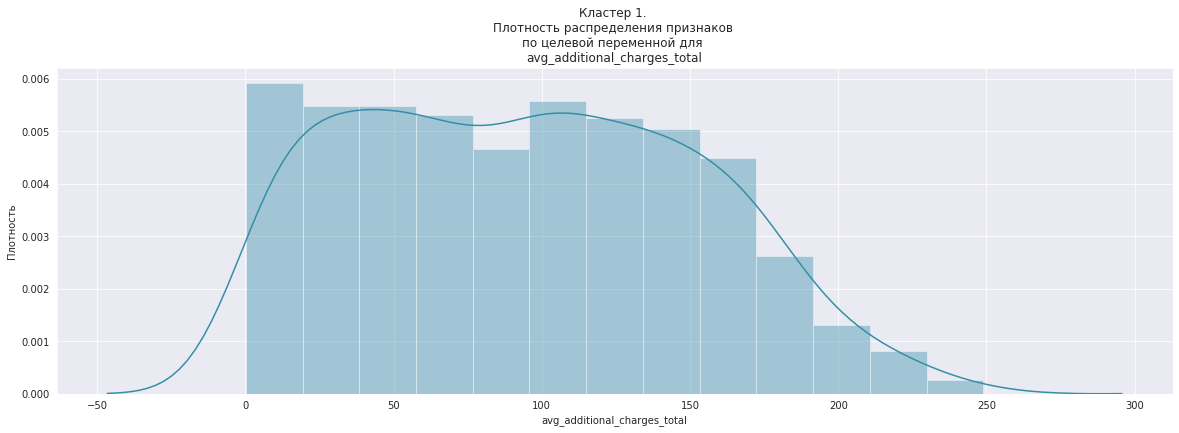

In [ ]:
plot_cluster(new_df, 1, real_features)

Кластер 1. Есть небольшой отток. Характеризуется непродолжительными контрактами, люди среднего возраста, незначительная дополнительная плата и покупка услуг

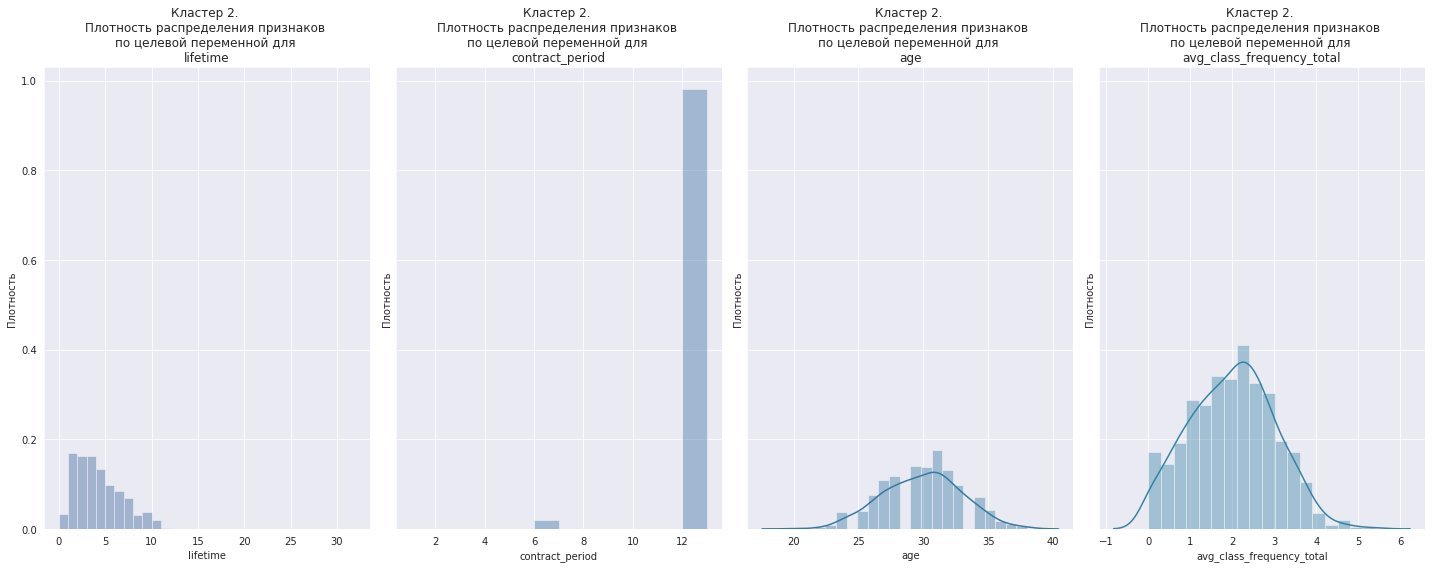

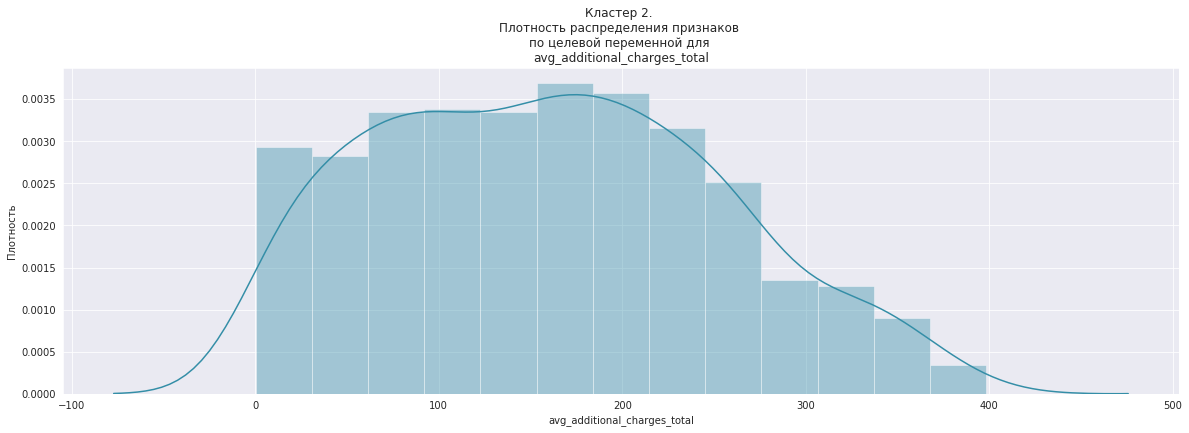

In [ ]:
plot_cluster(new_df, 2, real_features)

Кластер 2. Оттока почти нет. Характеризуется продолжительными контрактами, люди среднего возраста, незначительная дополнительная плата и покупка услуг

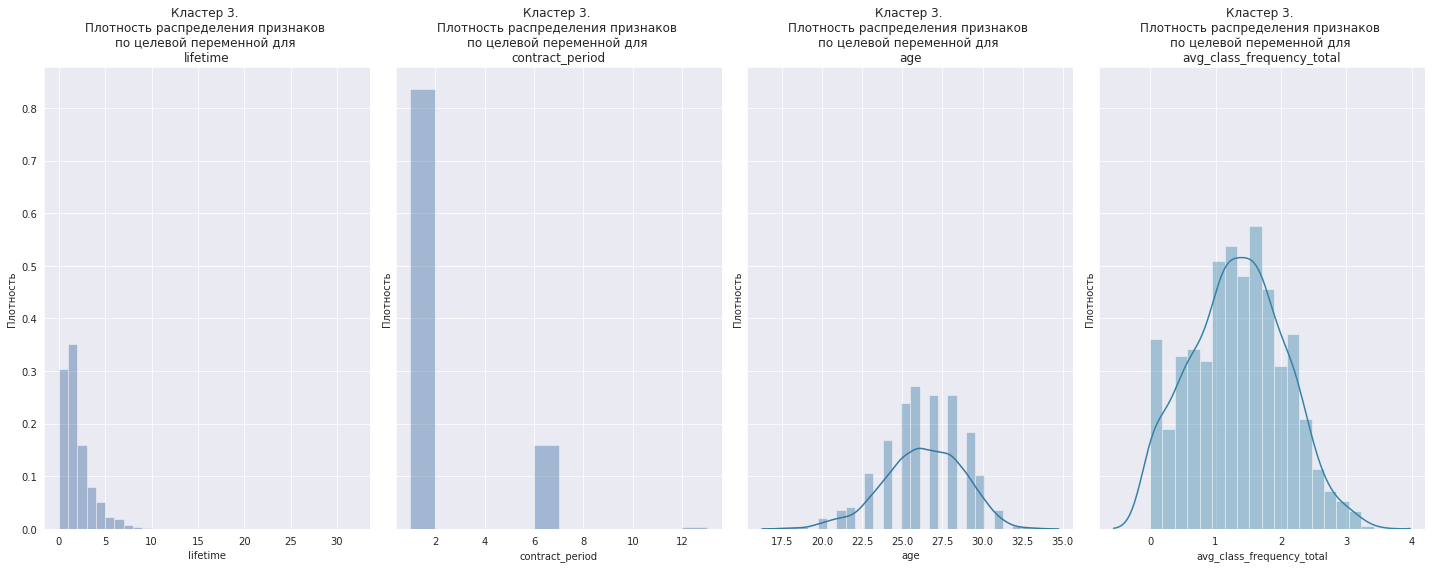

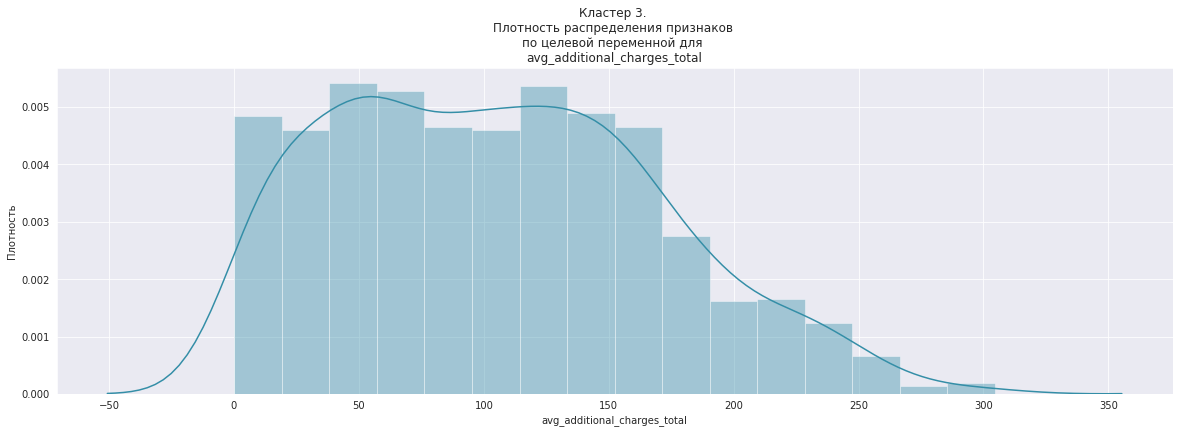

In [ ]:
plot_cluster(new_df, 3, real_features)

Кластер 3. Самый большой отток. Характеризуется непродолжительными контрактами, люди более молодого возраста, незначительная дополнительная плата и покупка услуг

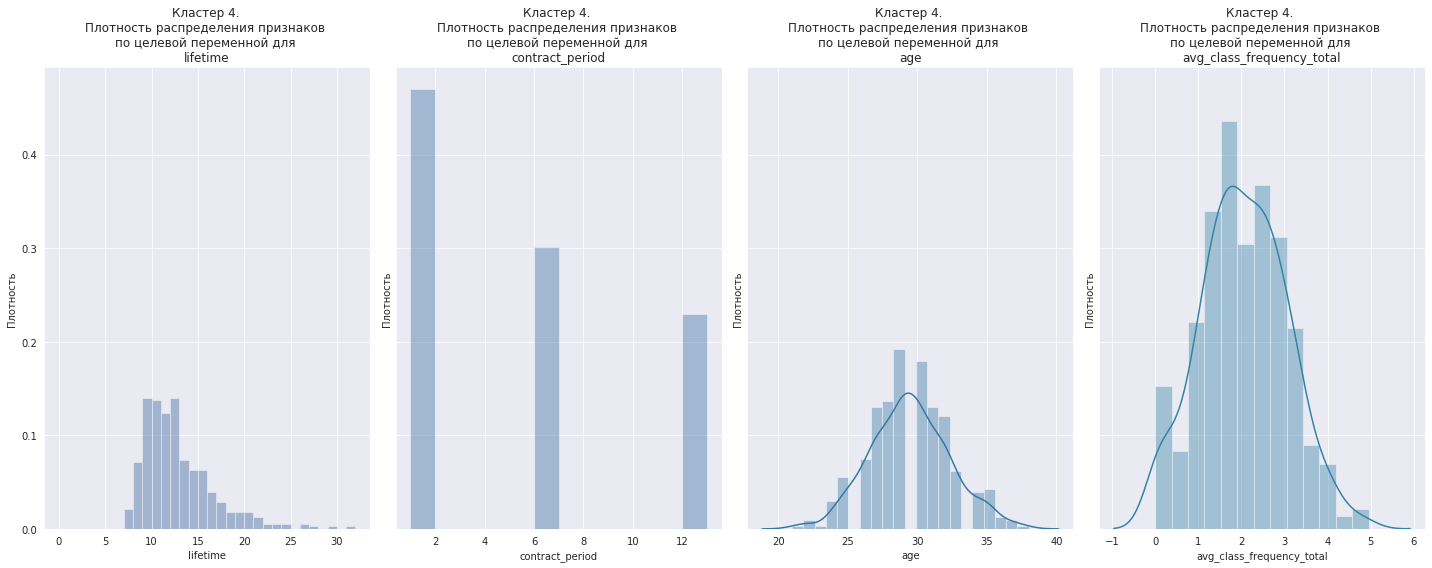

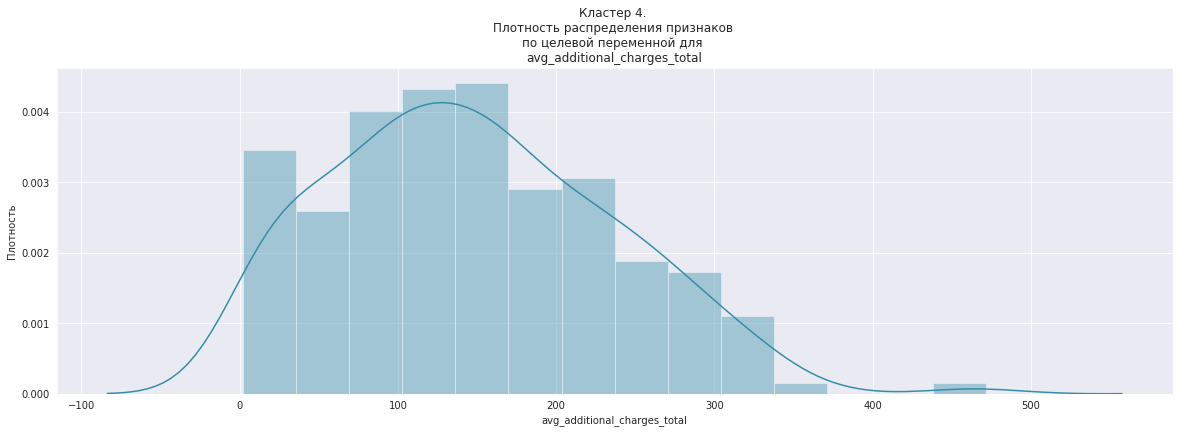

In [ ]:
plot_cluster(new_df, 4, real_features)

Кластер 4. Оттока нет - лучший кластер, но малочисленный. Характеризуется продолжительными контрактами, люди более среднего возраста, незначительная дополнительная плата и покупка услуг

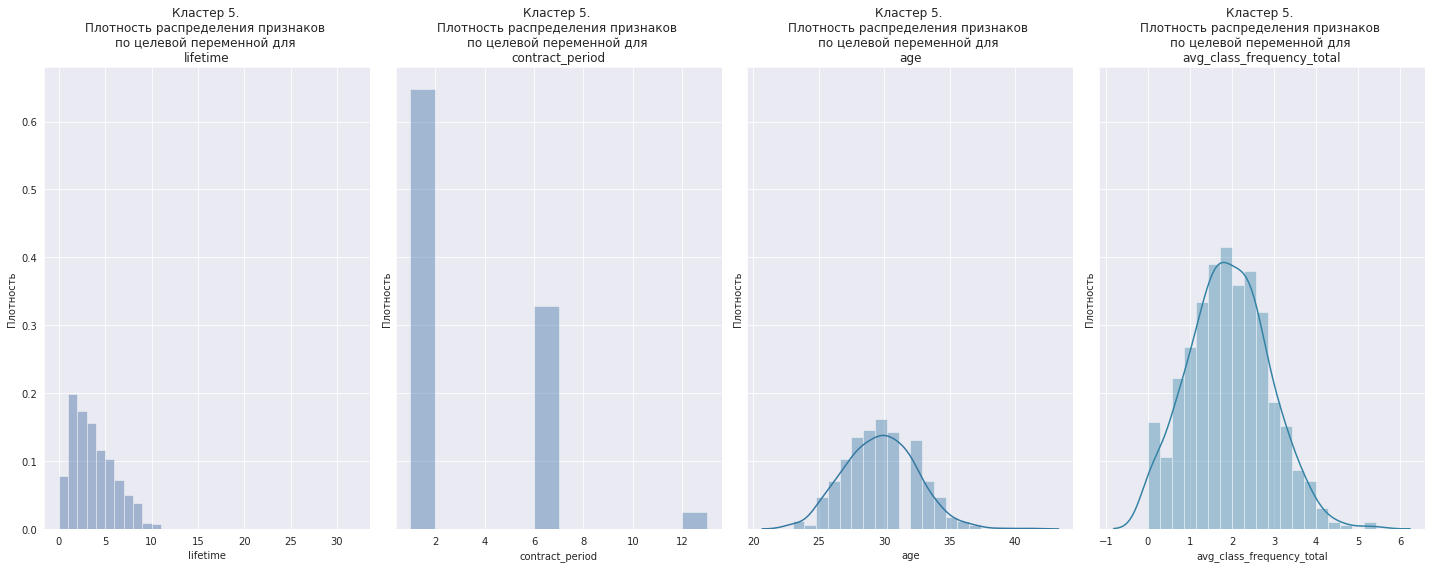

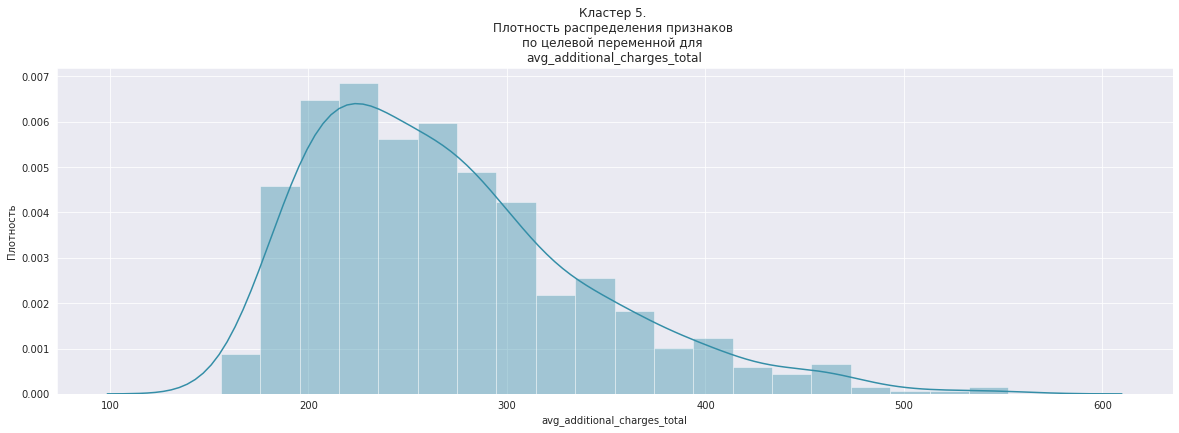

In [ ]:
plot_cluster(new_df, 5, real_features)

Кластер 5. Отток незначительный есть. Характеризуется контрактами средней продолжительности, люди среднего возраста, незначительная дополнительная плата и покупка услуг. В среднем тратят больше всех

Самый ненадежный кластер - 3, самый надежный кластер - 4

In [ ]:
new_df['cluster'].value_counts(normalize=True).to_frame()

,cluster
3,0.27675
1,0.23850
2,0.21700
5,0.17300
4,0.09475


Как видим, что доли людей по кластерам примерно равны. Самая малочисленная группа - 4, но при этом так нет оттока. Если рассматривать в совокупности, то лучшие группы будут 1 и 2 - на них стоит акцентировать свое внимание

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Базовые рекомендации по работе с клиентами

Мы провели анализ данных, составленных из множества клиентских анкет. Выделили кластеры клиентов, получили черновую модель для прогнозирования оттока клиента. Было выявлено значительное влияние на факт оттока - продолжительность контрактов. Необходимо сконцентрироваться на подписании долгосрочных договоров с клиентами, например, за счет скидок за покупку годового абонимента, предлагать бесплатные занятия с тренером в качестве подарка и подобные меры. Наиболее перспективные - договора - на 6 месяцев и 12 месяцев - такие клиенты реже уходят. Следует обратить внимание на развитие групповых занятий, а также предлагать дополнительные скидки и промоакции - `приведи друга`, продумать дополнительные партнерские программы.   

Самые верные клиенты - люди 30 лет, ходят 2-3 раза в неделю, у них договора на 6-12 месяцев, по партнерской программе, либо по приглашению друзей. Чаще всего уходят молодые люди 20-30 лет, с недолгосрочными договорами - необходимо продумать стимулирование покупки более длительных договоров для таких групп

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>
